In [ ]:
################################################################################################
# STEP 1: 1-1-DATA DOWNLOAD AND EXTRACTION
################################################################################################
# Download the raw data from GEO and extract its content.

!wget -O GSE147821_RAW.tar "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE147821&format=file"
!tar -xvf GSE147821_RAW.tar


--2025-04-09 07:39:19--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE147821&format=file
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2215567360 (2.1G) [application/x-tar]
Saving to: ‘GSE147821_RAW.tar’

GSE147821_RAW.tar   100%[===================>]   2.06G   108MB/s    in 40s     

2025-04-09 07:40:00 (52.2 MB/s) - ‘GSE147821_RAW.tar’ saved [2215567360/2215567360]

GSM4446535_10X_19_001.raw_feature_bc_matrix.h5
GSM4446536_10X_19_063.raw_feature_bc_matrix.h5
GSM4446537_10X_19_088.raw_feature_bc_matrix.h5
GSM4446538_10X_19_123.raw_feature_bc_matrix.h5
GSM4446539_10X_19_124.raw_feature_bc_matrix.h5
GSM4446540_10X_19_125.raw_feature_bc_matrix.h5
GSM4446541_10X_20_005.raw_feature_bc_matrix.h5
GSM4446542_10X_20_006.raw_feature_bc_matrix.h5
GSM4446543_10X_20_007.raw_feature_bc_matrix.h5
GSM47

In [ ]:
################################################################################################
# STEP 1: 1-2-INSTALLATION OF REQUIRED PACKAGES & DATA IMPORT
################################################################################################
# Install dependencies and import the necessary libraries.
!pip install scanpy anndata scvelo h5py leidenalg python-igraph

import os
import glob
import h5py
import scanpy as sc
import anndata as ad
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths and map sample IDs to developmental stages.
file_paths = [
    'GSM4446535_10X_19_001.raw_feature_bc_matrix.h5',
    'GSM4446536_10X_19_063.raw_feature_bc_matrix.h5',
    'GSM4446537_10X_19_088.raw_feature_bc_matrix.h5',
    'GSM4446538_10X_19_123.raw_feature_bc_matrix.h5',
    'GSM4446539_10X_19_124.raw_feature_bc_matrix.h5',
    'GSM4446540_10X_19_125.raw_feature_bc_matrix.h5',
    'GSM4446541_10X_20_005.raw_feature_bc_matrix.h5',
    'GSM4446542_10X_20_006.raw_feature_bc_matrix.h5',
    'GSM4446543_10X_20_007.raw_feature_bc_matrix.h5',
    'GSM4734601_10X_20_016.raw_feature_bc_matrix.h5',
    'GSM4734602_10X_20_031.raw_feature_bc_matrix.h5',
    'GSM4734603_10X_20_035.raw_feature_bc_matrix.h5',
    'GSM4734604_10X_20_036.raw_feature_bc_matrix.h5'
]

sample_map = {
    'GSM4446535': 'week8_001',
    'GSM4446536': 'week9_063',
    'GSM4446537': 'week6_088',
    'GSM4446538': 'week14_123',
    'GSM4446539': 'week12_124',
    'GSM4446540': 'week8_125',
    'GSM4446541': 'week9_005',
    'GSM4446542': 'week11_006',
    'GSM4446543': 'week9_007',
    'GSM4734601': 'week8_016',
    'GSM4734602': 'week9_031_paraganglia',
    'GSM4734603': 'week12_035',
    'GSM4734604': 'week12_036_extraadrenal'
}

# Load each dataset, label by sample, and concatenate into one AnnData object.
adata_list = []
for fp in file_paths:
    print(f"Loading: {fp}")
    # Extract the GSM id to map to a sample name.
    gsm_id = fp.split('_')[0]
    sample_name = sample_map.get(gsm_id, f"Sample_{gsm_id}")

    # Read 10x formatted data and ensure unique gene names.
    adata_temp = sc.read_10x_h5(fp)
    adata_temp.var_names_make_unique()

    # Annotate with sample information (developmental stage and internal ID)
    adata_temp.obs["sample_id"] = sample_name
    adata_list.append(adata_temp)

# Merge all samples into one AnnData object.
adata = ad.concat(adata_list)
print(adata)

Loading: GSM4446535_10X_19_001.raw_feature_bc_matrix.h5
Loading: GSM4446536_10X_19_063.raw_feature_bc_matrix.h5
Loading: GSM4446537_10X_19_088.raw_feature_bc_matrix.h5
Loading: GSM4446538_10X_19_123.raw_feature_bc_matrix.h5
Loading: GSM4446539_10X_19_124.raw_feature_bc_matrix.h5
Loading: GSM4446540_10X_19_125.raw_feature_bc_matrix.h5
Loading: GSM4446541_10X_20_005.raw_feature_bc_matrix.h5
Loading: GSM4446542_10X_20_006.raw_feature_bc_matrix.h5
Loading: GSM4446543_10X_20_007.raw_feature_bc_matrix.h5
Loading: GSM4734601_10X_20_016.raw_feature_bc_matrix.h5
Loading: GSM4734602_10X_20_031.raw_feature_bc_matrix.h5
Loading: GSM4734603_10X_20_035.raw_feature_bc_matrix.h5
Loading: GSM4734604_10X_20_036.raw_feature_bc_matrix.h5
AnnData object with n_obs × n_vars = 88333440 × 33538
    obs: 'sample_id'


In [ ]:
################################################################################################
# STEP 2: QUALITY CONTROL, NORMALIZATION, AND CELL CYCLE CORRECTION
################################################################################################
# ---- A. Basic Quality Control
# Filter low-quality cells and lowly expressed genes.
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# ---- B. Mitochondrial Gene Calculation
# Identify mitochondrial genes and compute relevant QC metrics.
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Remove cells with excessive gene counts and high mitochondrial percentages.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# ---- C. Data Normalization and Log Transformation
# Normalize the data and then log-transform.
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# ---- D. Identify Highly Variable Genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

# ---- E. Cell Cycle Scoring and Correction
# Ensure gene names are unique before scoring.
adata.var_names_make_unique()

# Define S-phase and G2/M-phase gene lists.
s_genes = ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2',
           'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'HELLS', 'RFC2', 'RPA2', 'NASP',
           'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2',
           'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2',
           'USP1', 'CLSPN', 'POLA1']

g2m_genes = ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80',
             'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4',
             'CCNB2', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1',
             'KIF20B', 'HMMR', 'CDC20', 'TTK', 'CDC25C', 'KIF2C']

# Filter these gene lists to those present in the dataset.
s_genes_filtered = [gene for gene in s_genes if gene in adata.var_names]
g2m_genes_filtered = [gene for gene in g2m_genes if gene in adata.var_names]

print("Filtered S genes:", s_genes_filtered)
print("Filtered G2M genes:", g2m_genes_filtered)

# Score cells by cell cycle phase.
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_filtered, g2m_genes=g2m_genes_filtered)
print(adata.obs.head())

Filtered S genes: ['PCNA', 'TYMS', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'HELLS', 'RAD51AP1', 'GMNN', 'WDR76', 'CCNE2', 'POLD3', 'ATAD2', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN']
Filtered G2M genes: ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'CENPF', 'TACC3', 'SMC4', 'CCNB2', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'TUBB4B', 'GTSE1', 'KIF20B', 'HMMR', 'CDC20', 'TTK', 'CDC25C', 'KIF2C']
                    sample_id  n_genes  n_genes_by_counts  total_counts  \
AAACCCACAAAGGCTG-1  week8_001     1654               1654        3112.0   
AAACCCAGTATCGAAA-1  week8_001      220                220        3218.0   
AAACCCATCTTCTAAC-1  week8_001      318                318         478.0   
AAACGAACACATAGCT-1  week8_001      589                589        8780.0   
AAACGCTAGGTAGACC-1  week8_001      339                339         717.0   

            

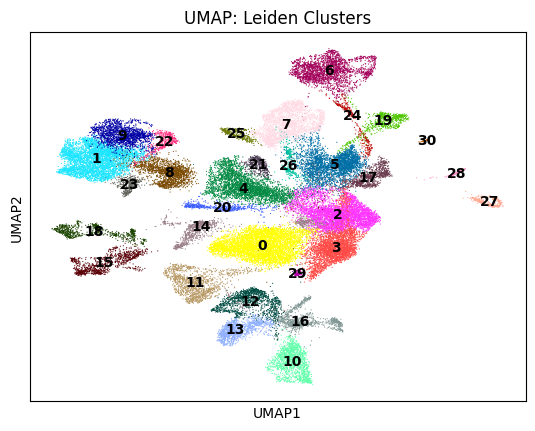

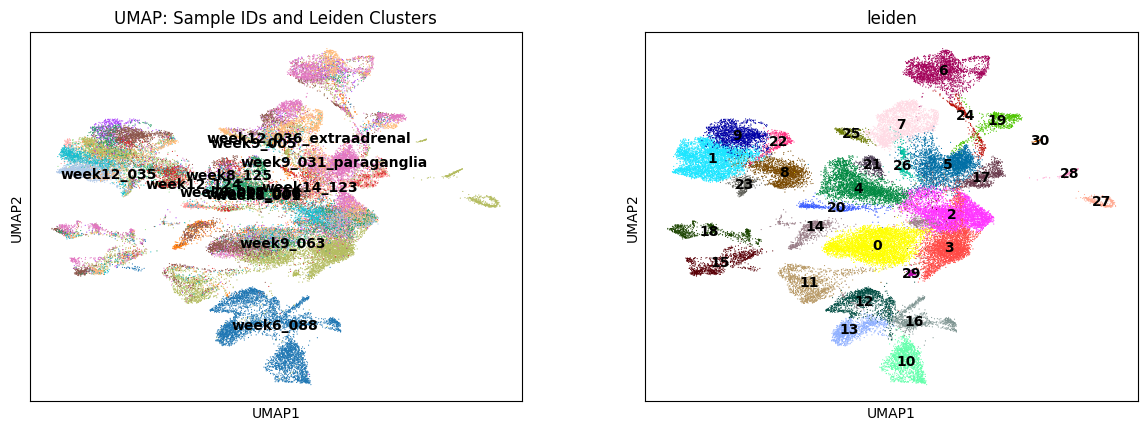

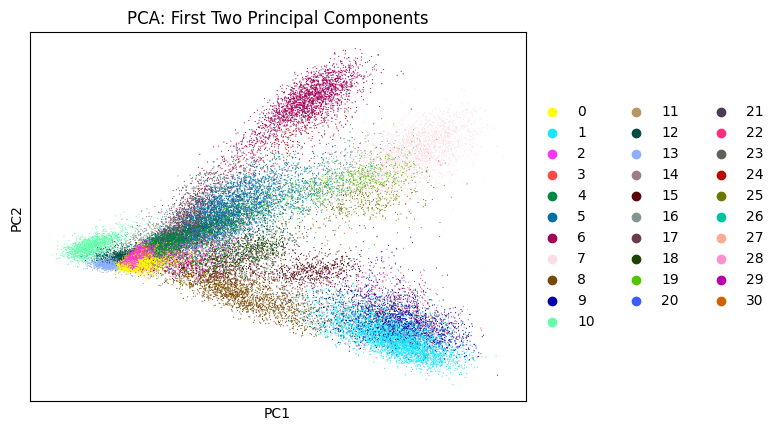

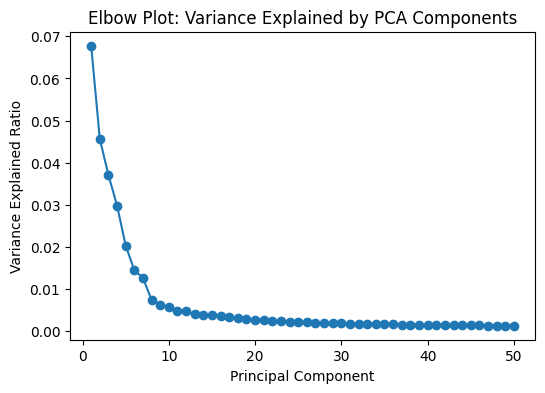

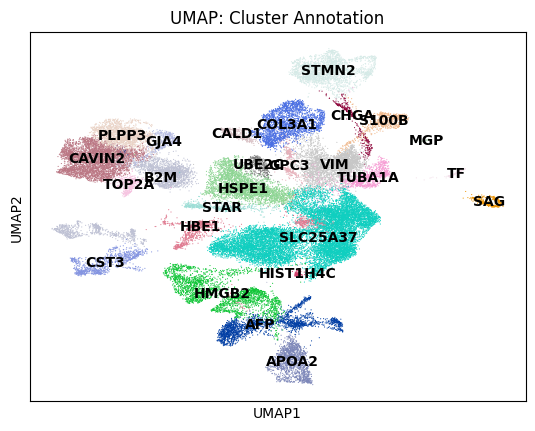

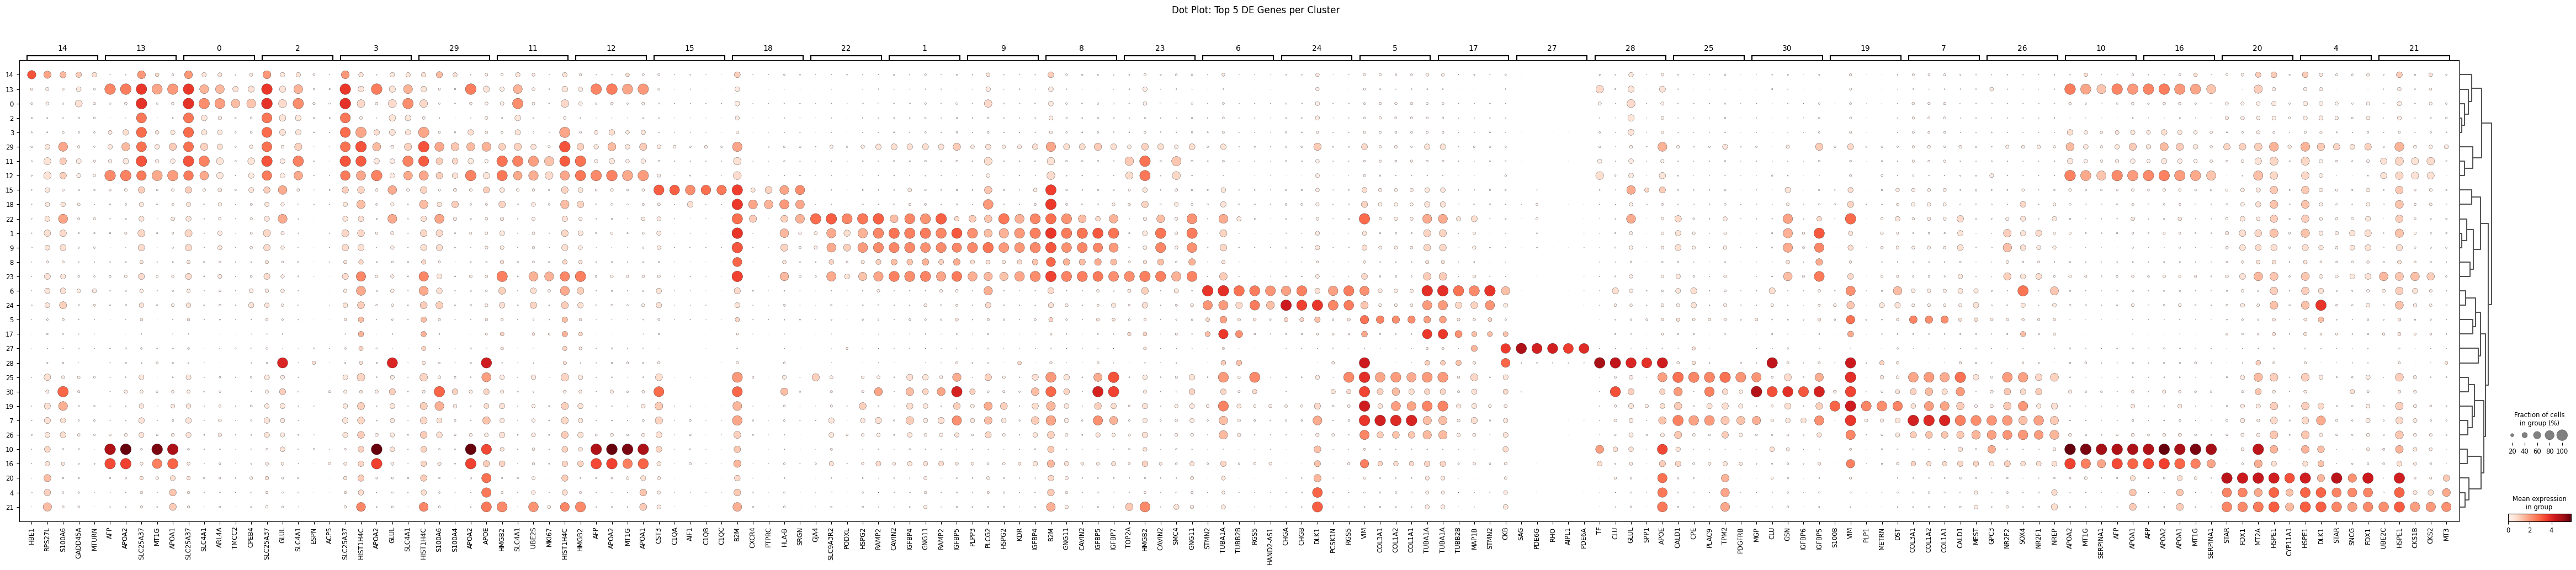

In [ ]:
################################################################################################
# STEP 3 and step 4: DIMENSIONALITY REDUCTION, CLUSTERING, AND CLUSTER ANNOTATION
################################################################################################
# ---- A. Dimensionality Reduction, Neighbors, and Clustering
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

# ---- B. UMAP Plots
# UMAP plot colored by Leiden clusters.
sc.pl.umap(adata, color='leiden', title='UMAP: Leiden Clusters', legend_loc='on data')
# UMAP plot colored by sample IDs in addition to clusters.
sc.pl.umap(adata, color=['sample_id', 'leiden'],
           title='UMAP: Sample IDs and Leiden Clusters', legend_loc='on data')

# ---- C. PCA and Elbow Plot Visualization
sc.pl.pca(adata, color='leiden', title='PCA: First Two Principal Components')
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(adata.uns['pca']['variance_ratio']) + 1),
         adata.uns['pca']['variance_ratio'], marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.title('Elbow Plot: Variance Explained by PCA Components')
plt.show()

# ---- D. Cluster Annotation and Differential Expression Analysis
# Identify marker genes for each cluster.
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
# Extract top marker gene per cluster for annotation.
marker_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0].to_dict()
adata.obs['cluster_annotation'] = adata.obs['leiden'].map(marker_genes)
# UMAP plot with cluster annotation.
sc.pl.umap(adata, color=['cluster_annotation'], legend_loc='on data', title='UMAP: Cluster Annotation')
# Dot plot for the top 5 differentially expressed genes per cluster.
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, title="Dot Plot: Top 5 DE Genes per Cluster")

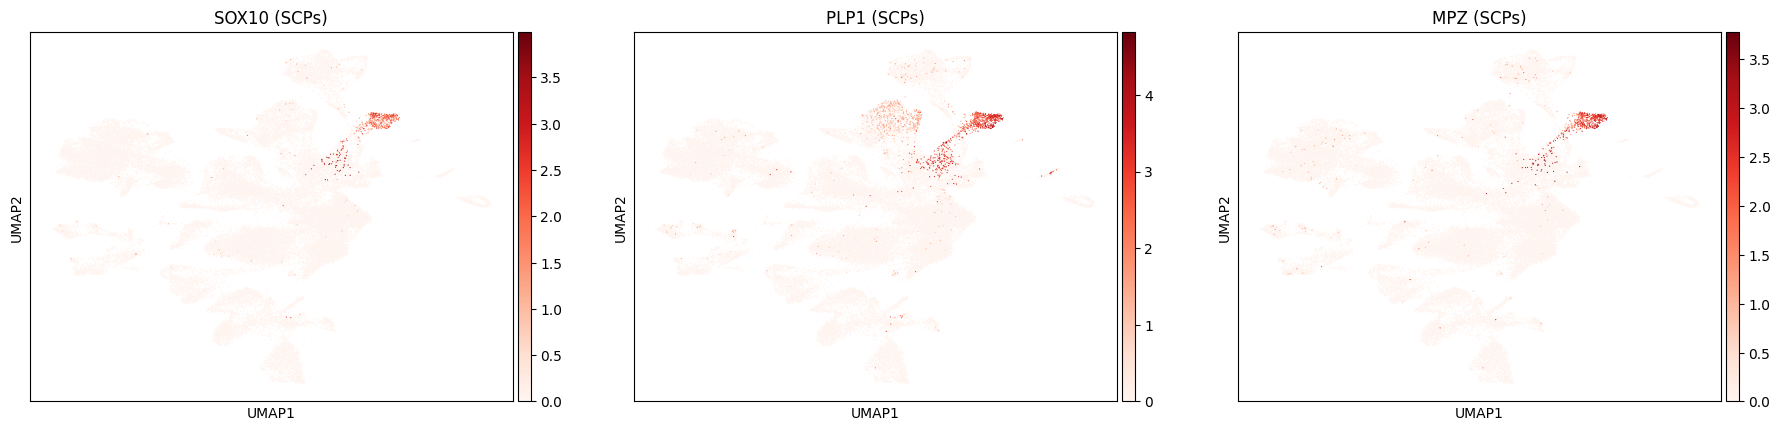

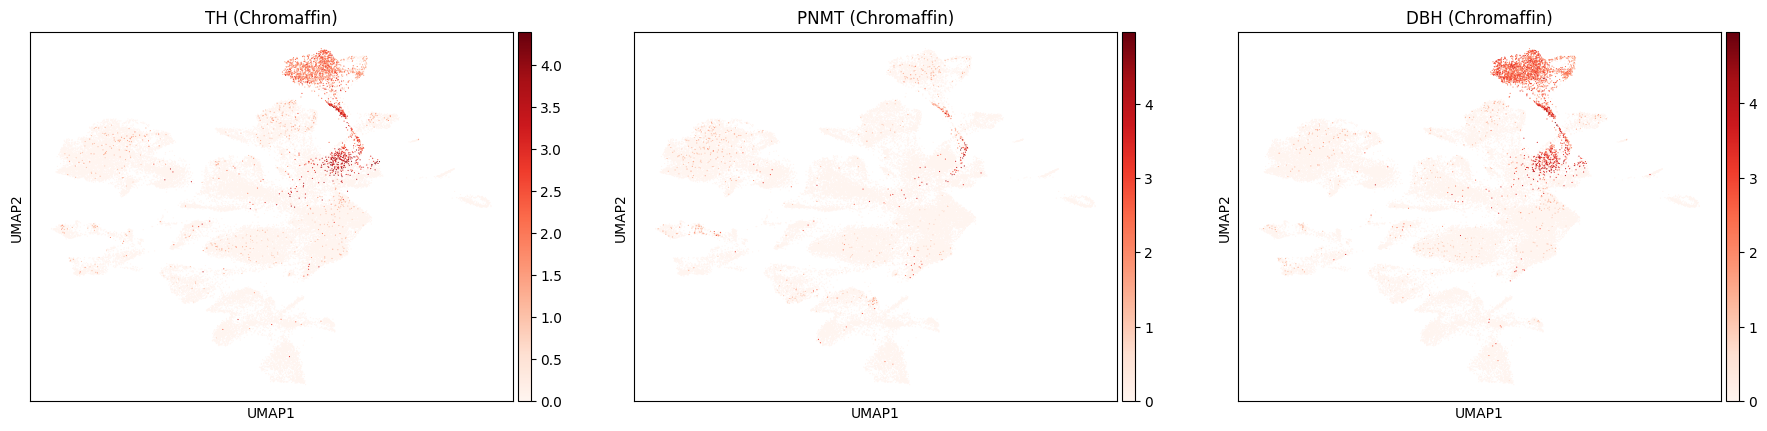

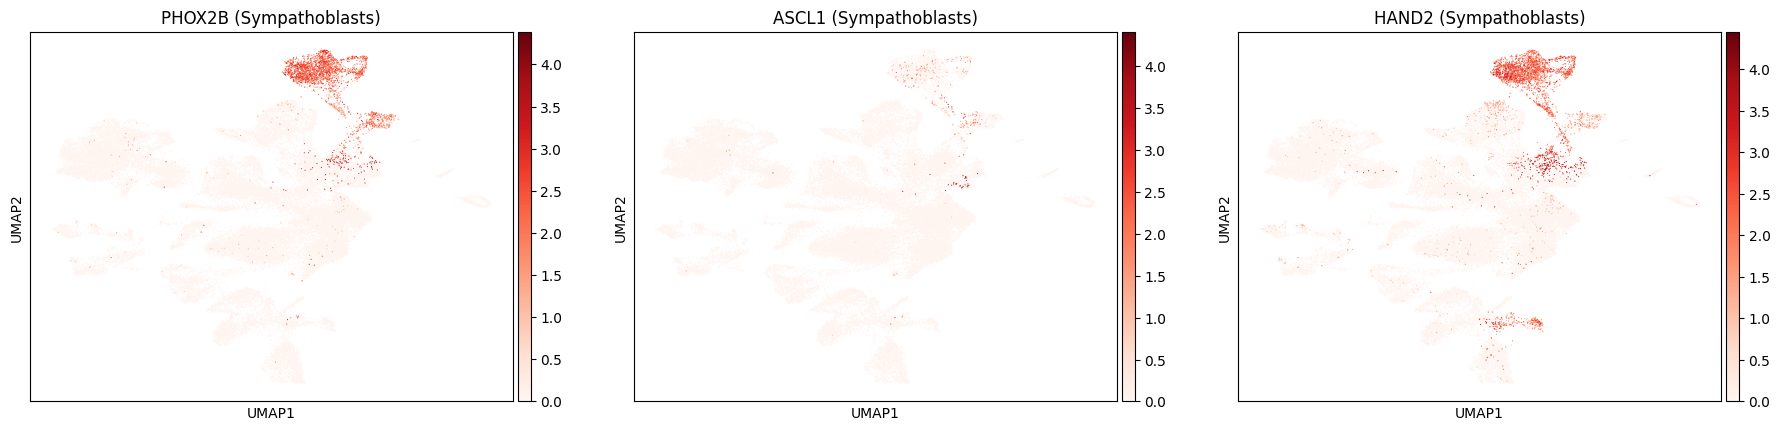

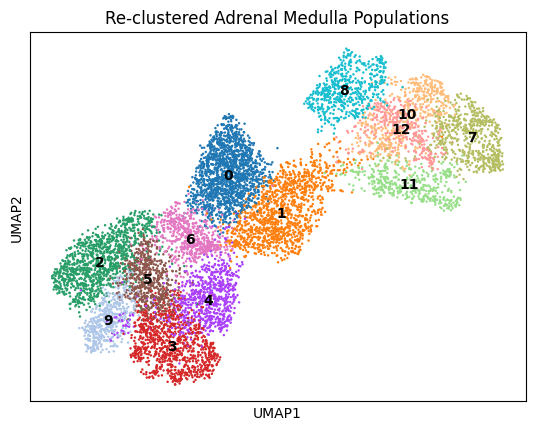

In [ ]:
################################################################################################
# STEP 5: SUB-SETTING AND RE-CLUSTERING OF ADRENAL MEDULLA CELL POPULATIONS
################################################################################################
# Define marker genes for cell types within adrenal medulla.
markers = {
    'SCPs': ['SOX10', 'PLP1', 'MPZ'],
    'Chromaffin': ['TH', 'PNMT', 'DBH'],
    'Sympathoblasts': ['PHOX2B', 'ASCL1', 'HAND2']
}

# Visualize marker gene expression on UMAP to assess cluster separation.
for cell_type, genes in markers.items():
    sc.pl.umap(adata, color=genes, cmap='Reds', title=[f"{gene} ({cell_type})" for gene in genes])

# Optional re-clustering:
# Here we select cells from key clusters (for example, using Leiden cluster numbers determined from prior analysis).
# Adjust target_clusters as needed based on inspection of the UMAP.
target_clusters = ['2', '5', '7']  # <-- Edit these numbers to target SCPs, Chromaffin, and Sympathoblast clusters.
adrenal_subset = adata[adata.obs['leiden'].isin(target_clusters)].copy()

# You may run further clustering on the subset to improve resolution.
sc.pp.pca(adrenal_subset)
sc.pp.neighbors(adrenal_subset)
sc.tl.umap(adrenal_subset)
sc.tl.leiden(adrenal_subset)
sc.pl.umap(adrenal_subset, color='leiden', title='Re-clustered Adrenal Medulla Populations', legend_loc='on data')

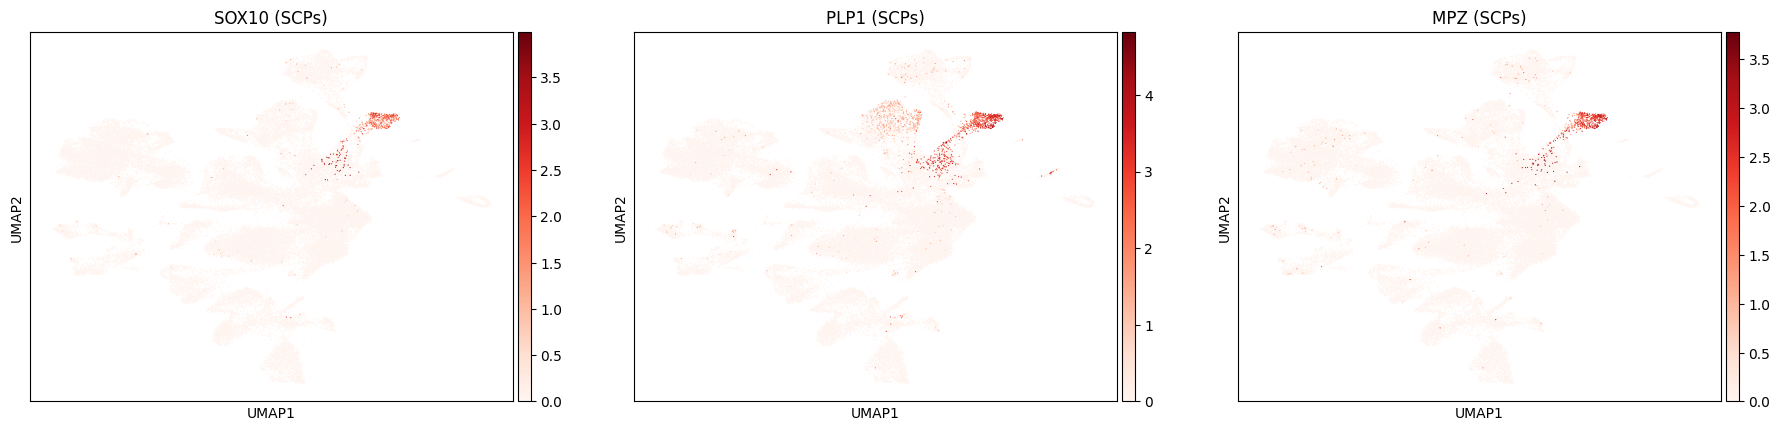

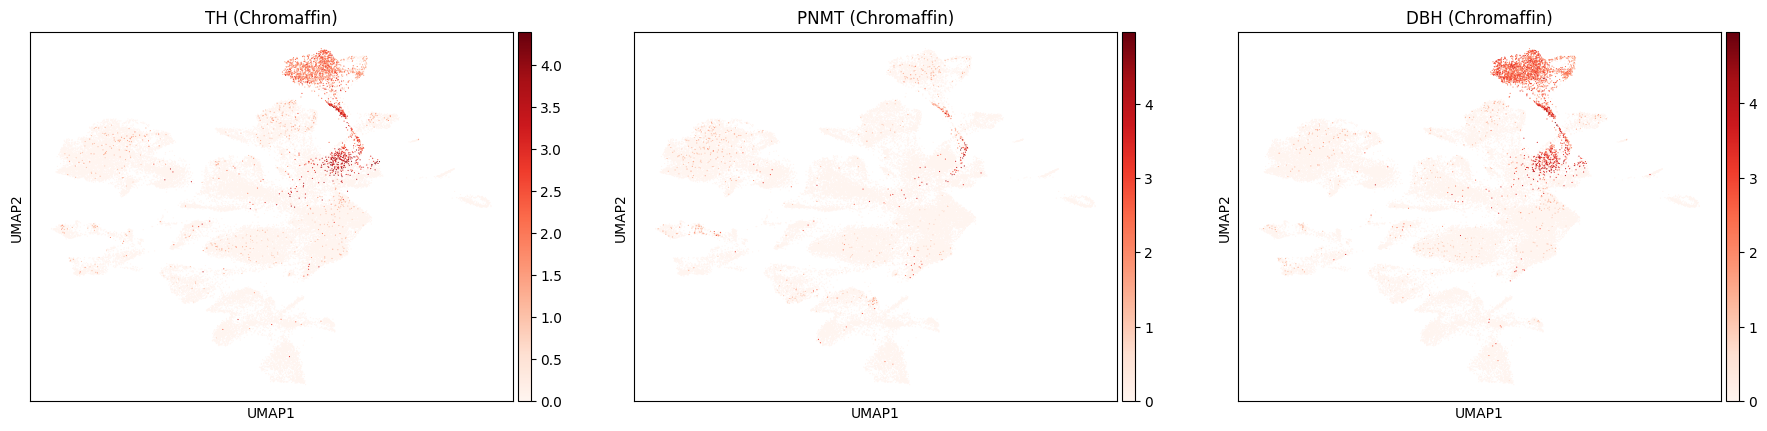

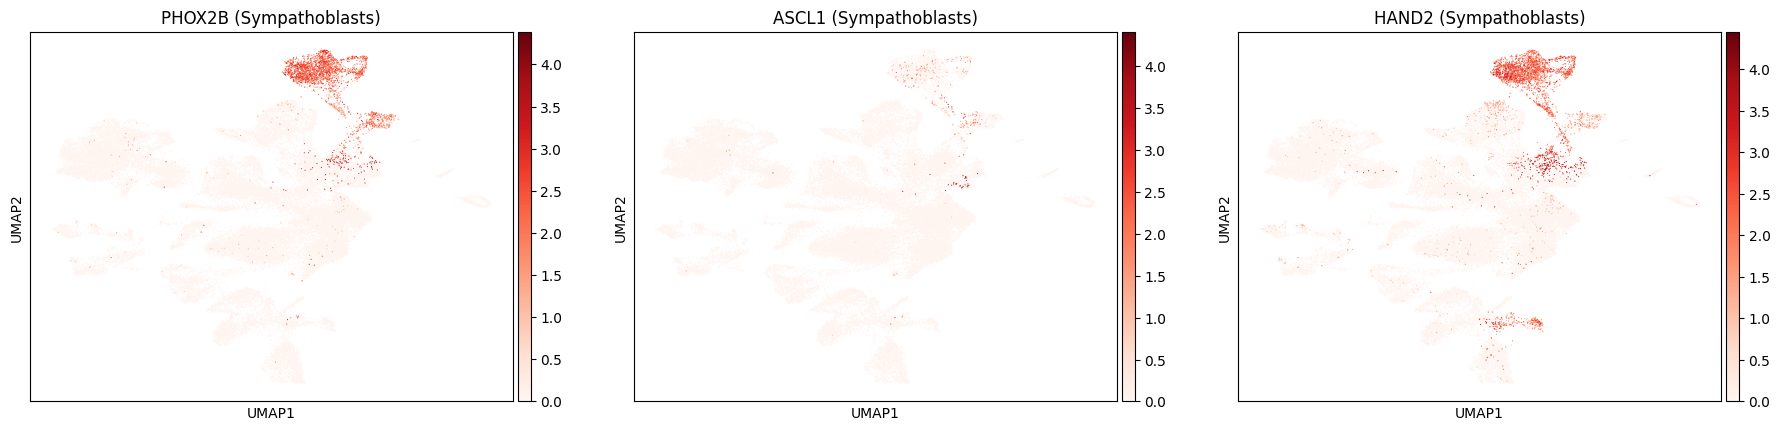

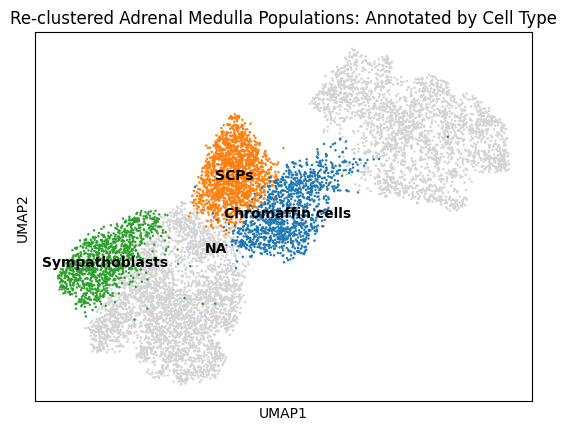

In [ ]:
################################################################################################
# STEP 5: SUB-SETTING AND RE-CLUSTERING OF ADRENAL MEDULLA CELL POPULATIONS
################################################################################################
# Define marker genes for cell types within the adrenal medulla.
markers = {
    'SCPs': ['SOX10', 'PLP1', 'MPZ'],
    'Chromaffin': ['TH', 'PNMT', 'DBH'],
    'Sympathoblasts': ['PHOX2B', 'ASCL1', 'HAND2']
}

# Visualize marker gene expression on UMAP for each cell type to assess cluster separation.
for cell_type, genes in markers.items():
    sc.pl.umap(adata, color=genes, cmap='Reds',
               title=[f"{gene} ({cell_type})" for gene in genes])

# Optional re-clustering:
# Select cells from key clusters identified in previous UMAP visualization.
# Adjust target_clusters as needed based on the inspection of the UMAP.
target_clusters = ['2', '5', '7']  # These numbers correspond to the clusters of interest.
adrenal_subset = adata[adata.obs['leiden'].isin(target_clusters)].copy()

# Further clustering on the subset to improve resolution.
sc.pp.pca(adrenal_subset)
sc.pp.neighbors(adrenal_subset)
sc.tl.umap(adrenal_subset)
sc.tl.leiden(adrenal_subset)

# IMPORTANT: After re-clustering, the clusters may be renumbered.
# To facilitate interpretation, create a mapping that replaces numeric cluster IDs with informative cell type labels.
# Adjust the mapping based on the re-clustered results.
# For example, here we assume the re-clustering resulted in clusters '0', '1', and '2',
# which we map to "SCPs", "Chromaffin cells", and "Sympathoblasts" respectively.
cluster_to_celltype = {
    '0': 'SCPs',
    '1': 'Chromaffin cells',
    '2': 'Sympathoblasts'
}

# Create a new column in the AnnData object with the custom cell type labels.
adrenal_subset.obs['cell_type_annotation'] = adrenal_subset.obs['leiden'].map(cluster_to_celltype)

# Plot the re-clustered UMAP, now colored by the informative cell type labels instead of numeric cluster IDs.
sc.pl.umap(adrenal_subset, color='cell_type_annotation',
           title='Re-clustered Adrenal Medulla Populations: Annotated by Cell Type',
           legend_loc='on data')


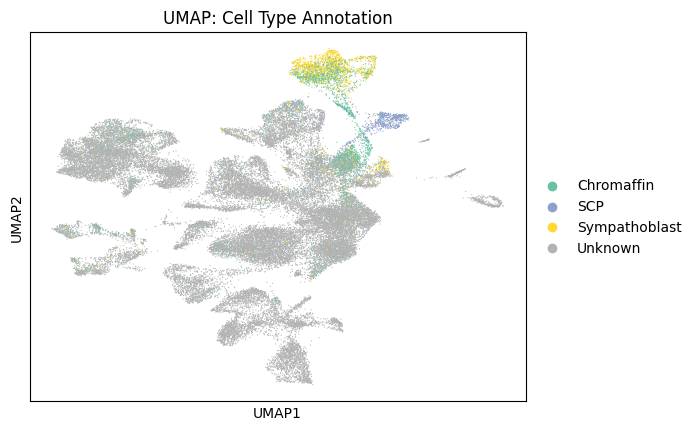


Trajectory: SCP_vs_Chromaffin
Analyzing cell types: ['SCP', 'Chromaffin']
Using genes: ['ISL1', 'PNMT', 'PLP1', 'CHGA', 'SOX10']


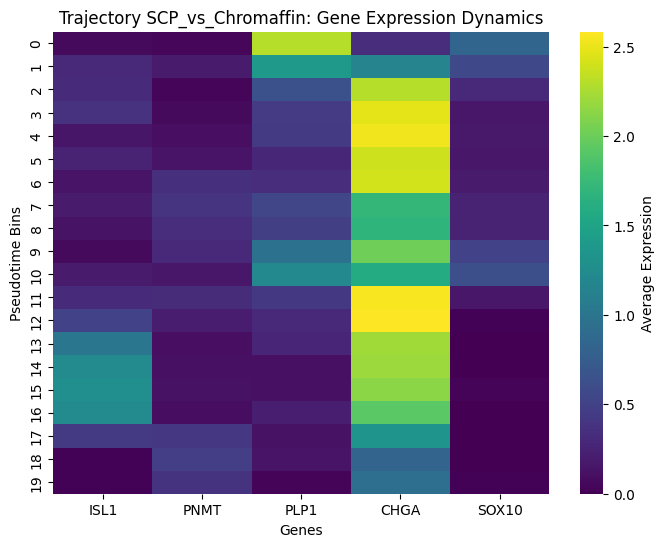


Trajectory: SCP_vs_Sympathoblast
Analyzing cell types: ['SCP', 'Sympathoblast']
Using genes: ['ISL1', 'PLP1', 'PRPH', 'ELAVL4', 'SOX10']


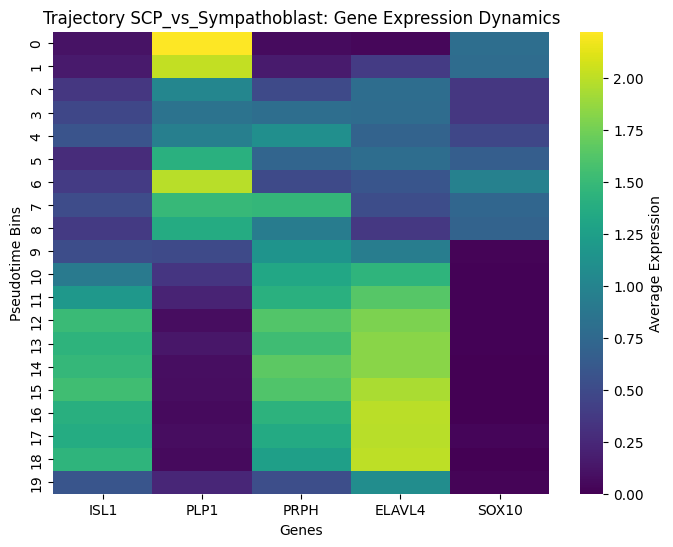


Trajectory: Chromaffin_vs_Sympathoblast
Analyzing cell types: ['Chromaffin', 'Sympathoblast']
Using genes: ['PNMT', 'CHGA', 'ELAVL4', 'PRPH']


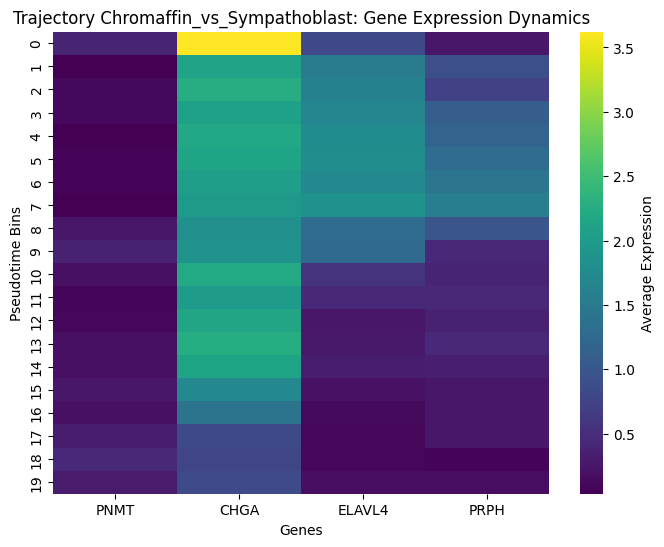

In [ ]:
################################################################################################
# STEP 6: TRAJECTORY / GENE EXPRESSION DYNAMICS ANALYSIS (ALTERNATIVE 6a)
################################################################################################
# Here we perform trajectory analysis between the adrenal medulla cell types (SCPs, Chromaffin, Sympathoblasts)
# and visualize gene expression dynamics along pseudotime.

# ---- A. Marker Definitions for Cell-Level Trajectory Analysis
scp_markers = ['SOX10', 'PLP1', 'ISL1']
chromaffin_markers = ['CHGA', 'PNMT']
sympathoblast_markers = ['ELAVL4', 'PRPH']

# Create a dictionary of marker sets.
marker_dict = {
    'SCP': scp_markers,
    'Chromaffin': chromaffin_markers,
    'Sympathoblast': sympathoblast_markers
}

# Calculate average marker expression per cell.
cell_scores = pd.DataFrame(index=adata.obs_names)
for cell_type, markers in marker_dict.items():
    valid_genes = [gene for gene in markers if gene in adata.var_names]
    if valid_genes:
        scores = adata[:, valid_genes].X.mean(axis=1)
        scores = scores.A1 if hasattr(scores, 'A1') else scores
        cell_scores[cell_type] = scores
    else:
        cell_scores[cell_type] = 0

# Assign cell type labels if the maximum average expression exceeds a threshold.
threshold = 0.5
def assign_cell_type(row):
    max_val = row.max()
    if max_val > threshold:
        return row.idxmax()
    else:
        return 'Unknown'

adata.obs['cell_type'] = cell_scores.apply(assign_cell_type, axis=1)
sc.pl.umap(adata, color='cell_type', palette='Set2', title='UMAP: Cell Type Annotation')

# ---- B. Trajectory Analysis Between Selected Cell Types
# Define trajectory pairs and the union of marker genes for each pair.
trajectory_pairs = {
    'SCP_vs_Chromaffin': {
        'cell_types': ['SCP', 'Chromaffin'],
        'genes': list(set(scp_markers + chromaffin_markers))
    },
    'SCP_vs_Sympathoblast': {
        'cell_types': ['SCP', 'Sympathoblast'],
        'genes': list(set(scp_markers + sympathoblast_markers))
    },
    'Chromaffin_vs_Sympathoblast': {
        'cell_types': ['Chromaffin', 'Sympathoblast'],
        'genes': list(set(chromaffin_markers + sympathoblast_markers))
    }
}

import numpy as np

# Loop over trajectory pairs, subset data accordingly, and compute pseudotime using DPT.
for traj_name, traj_info in trajectory_pairs.items():
    cell_types = traj_info['cell_types']
    genes = [g for g in traj_info['genes'] if g in adata.var_names]

    print(f"\nTrajectory: {traj_name}")
    print(f"Analyzing cell types: {cell_types}")
    print(f"Using genes: {genes}")

    # Subset the data to contain only the cells of interest.
    adata_subset = adata[adata.obs['cell_type'].isin(cell_types)].copy()

    # Preprocess for trajectory inference.
    sc.pp.pca(adata_subset)
    sc.pp.neighbors(adata_subset)

    # Select a root cell for diffusion pseudotime (DPT).
    if 'SCP' in cell_types:
        scp_cells = np.flatnonzero(adata_subset.obs['cell_type'] == 'SCP')
        root_idx = int(scp_cells[0]) if len(scp_cells) > 0 else 0
    else:
        root_idx = 0
    adata_subset.uns['iroot'] = root_idx

    # Compute diffusion pseudotime.
    sc.tl.dpt(adata_subset)
    if 'dpt_pseudotime' not in adata_subset.obs.columns:
        raise KeyError("dpt_pseudotime not found. Ensure sc.tl.dpt() ran properly.")

    pseudotime = adata_subset.obs['dpt_pseudotime']
    sorted_idx = np.argsort(pseudotime)

    # Build a DataFrame of expression values for genes of interest.
    expr_df = pd.DataFrame(adata_subset.to_df()[genes], index=adata_subset.obs_names)
    expr_df = expr_df.loc[adata_subset.obs_names[sorted_idx], :]

    # Bin cells into quantiles along pseudotime.
    n_bins = 20
    pseudotime_sorted = pseudotime.loc[adata_subset.obs_names[sorted_idx]]
    expr_df['bin'] = pd.qcut(pseudotime_sorted, q=n_bins, labels=False)

    # Compute mean gene expression per bin.
    binned_expr = expr_df.groupby('bin').mean()

    # Plot a heatmap of gene expression dynamics along the trajectory.
    plt.figure(figsize=(8, 6))
    sns.heatmap(binned_expr, cmap='viridis', cbar_kws={'label': 'Average Expression'},
                yticklabels=True, xticklabels=True)
    plt.title(f"Trajectory {traj_name}: Gene Expression Dynamics")
    plt.xlabel("Genes")
    plt.ylabel("Pseudotime Bins")
    plt.show()